## How to generate pulsar frequencies


This notebook explores how to take some pulsar data (`.tim` and `.par` files) and generate some frequencies $f$ for use with state-spce methods like Kalman filtering 


---


## 1. Imports and setup

We use the [libstempo](https://github.com/vallis/libstempo) python wrapper for `tempo2`. Specifically we use L.Dunn's branch, see [Liam's installation notes](https://gist.github.com/ldunn/04a20627941df1a7f96f6fd5a0a291b9).

When importing `tempo2` we have to set the `TEMPO2` environment variable. We don't have to do this when working directly in the shell, but inside a Jupyter notebook [it seems necessary (?!)](https://github.com/microsoft/vscode/issues/163612)

In [4]:
import os 
os.environ['TEMPO2'] = '/fred/oz022/tkimpson/tempo2/T2runtime' # set the environment variable
import libstempo

## 2. Generating clean TOAs

Lets look at how to generate some "clean" TOAs.

By "clean", I mean TOAs in the pulsar frame, that have been corrected for e.g. barycentering, have no measurement noise, etc. 



In [8]:
# First define the data to use
import glob
path_to_data = '../mdc/IPTA_Challenge1_open/Challenge_Data/Dataset1/'
list_of_par_files = sorted(glob.glob(path_to_data+'/*.par'))
list_of_tim_files = sorted(glob.glob(path_to_data+'/*.tim'))
assert len(list_of_par_files) == len(list_of_tim_files)

In [20]:
#Pick a particular pulsar
psr_idx = 0
par_file = list_of_par_files[psr_idx]
tim_file = list_of_tim_files[psr_idx]

In [31]:
#Generate a tempopulsar object 
psr = libstempo.tempopulsar(parfile=par_file,timfile=tim_file)

[tempo2Util.C:401] Warning: [DUP1] duplicated warnings have been suppressed.


/tmp/ipykernel_2107129/3471839918.py:2: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  psr = libstempo.tempopulsar(parfile=par_file,timfile=tim_file)


In [40]:
#Get TOAs and phases 
barycentric_toas = psr.toas() #cf. psr.stoas "site-toas" ?
phases = psr.phase()

Text(0, 0.5, '$\\phi$')

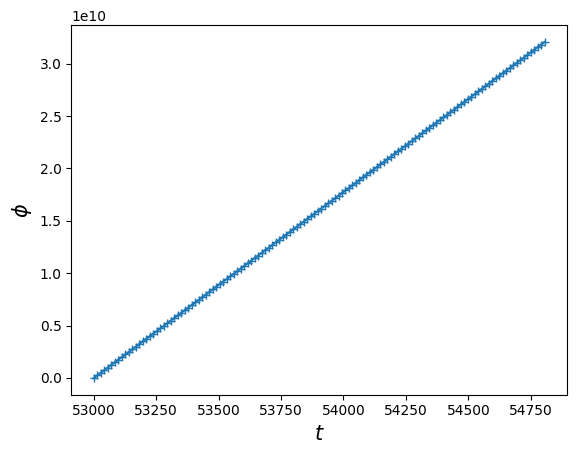

In [49]:
#Plot TOA vs phase
import matplotlib.pyplot as plt 
plt.plot(barycentric_toas,phases,marker='+')

fs = 15
plt.xlabel(r'$t$',fontsize=fs)
plt.ylabel(r'$\phi$',fontsize=fs)

This looks reasonable, and behaves as I might expect. 